In [33]:
%pip install matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

Note: you may need to restart the kernel to use updated packages.


In [34]:
df = pd.read_csv("waqi_global_dataset_with_categoricals.csv")

print("Dataset shape:", df.shape)
print(df.head())

Dataset shape: (12815, 20)
     uid                 time    aqi            city_name        lat  \
0    428  2025-09-21 01:00:00  107.0        Osorno, Chile -40.584479   
1   8821  2025-09-21 01:00:00   63.0       Mirasol, Chile -41.479507   
2  14756  2025-09-21 02:00:00   46.0  Puerto Varas, Chile -41.328935   
3    445  2025-09-21 02:00:00  152.0     Coyhaique, Chile -45.579964   
4  10699  2025-09-21 01:00:00   38.0      Vialidad, Chile -45.406800   

         lon   pm25  pm10  no2  so2  co  o3  temp_c  humidity_pct  \
0 -73.118720  107.0  37.0  NaN  NaN NaN NaN     8.7          93.8   
1 -72.968756   63.0   NaN  NaN  NaN NaN NaN     8.0          93.0   
2 -72.968209   46.0  12.0  NaN  NaN NaN NaN     8.0          93.0   
3 -72.061126  152.0  46.0  NaN  NaN NaN NaN     6.0          87.0   
4 -72.696260   38.0   NaN  NaN  NaN NaN NaN     6.0          93.0   

   pressure_hpa  wind_speed_mps             aqi_category  month  season  \
0        1008.3             0.9  Unhealthy for Sen

In [35]:
describe = df.describe()
print(describe)
info = df.info()
print(info)

                uid           aqi           lat           lon          pm25  \
count  12815.000000  12701.000000  12815.000000  12815.000000  11520.000000   
mean    7357.636208     35.909220     34.194734     31.930015     34.837778   
std     4245.991838     38.628758     20.609165     84.526243     32.296188   
min        1.000000      0.000000    -53.158295   -161.767000      1.000000   
25%     3781.500000     18.000000     31.319854     -5.726443     15.000000   
50%     7119.000000     29.000000     38.454722     20.960068     25.000000   
75%    10725.500000     45.000000     46.602340    114.906400     48.000000   
max    14937.000000   2138.000000     69.656250    176.919127    832.000000   

               pm10          no2          so2           co           o3  \
count  10660.000000  9953.000000  8198.000000  6592.000000  9131.000000   
mean      19.447017     5.834268     3.043513     3.588557    20.915205   
std       43.414633     6.727467     4.942867    12.075955    1

In [36]:
before = df.shape[0]
df = df.drop_duplicates()
print(f"Removed {before - df.shape[0]} duplicate rows")

Removed 0 duplicate rows


In [37]:
target = "aqi_category"
X = df.drop(columns=[target])
y = df[target]

In [38]:
# Separate numeric & categorical
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=["object"]).columns.tolist()

In [39]:
# Force numeric conversion (turn invalid strings → NaN)
for c in num_features:
    X[c] = pd.to_numeric(X[c], errors="coerce")


In [40]:
# Print missing values per feature BEFORE filling
print("Missing values per feature BEFORE filling:")
print("Numerical Features:")
for c in num_features:
    missing_count = X[c].isna().sum()
    if missing_count > 0:
        print(f"  {c}: {missing_count} missing values ({missing_count/len(X)*100:.2f}%)")

print("\nCategorical Features:")
for c in cat_features:
    missing_count = X[c].isna().sum()
    if missing_count > 0:
        print(f"  {c}: {missing_count} missing values ({missing_count/len(X)*100:.2f}%)")

# Check target variable missing values
target_missing = y.isna().sum()
print(f"\nTarget variable ('{target}') missing values: {target_missing} ({target_missing/len(y)*100:.2f}%)")

print("\n" + "="*50)

Missing values per feature BEFORE filling:
Numerical Features:
  aqi: 114 missing values (0.89%)
  pm25: 1295 missing values (10.11%)
  pm10: 2155 missing values (16.82%)
  no2: 2862 missing values (22.33%)
  so2: 4617 missing values (36.03%)
  co: 6223 missing values (48.56%)
  o3: 3684 missing values (28.75%)
  temp_c: 418 missing values (3.26%)
  humidity_pct: 495 missing values (3.86%)
  pressure_hpa: 635 missing values (4.96%)
  wind_speed_mps: 739 missing values (5.77%)

Categorical Features:

Target variable ('aqi_category') missing values: 0 (0.00%)



In [41]:
# Fill numeric NaNs with mean
for c in num_features:
    X[c] = X[c].fillna(X[c].mean())

# Fill categorical NaNs with mode
for c in cat_features:
    X[c] = X[c].fillna(X[c].mode()[0])

before_count = len(y)

# Drop rows with missing target
mask = y.notna()
X, y = X[mask], y[mask]

# Calculate and print drop count
after_count = len(y)
dropped_count = before_count - after_count
print(f"Dropped {dropped_count} rows with missing target values")
print(f"Dataset size: {before_count} → {after_count} rows")

Dropped 0 rows with missing target values
Dataset size: 12815 → 12815 rows


In [ ]:
def remove_outliers(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - k*iqr, q3 + k*iqr
    
    # Create boolean mask for non-outliers
    non_outlier_mask = (s >= lower) & (s <= upper)
    
    return non_outlier_mask

print("Outlier removal summary:")
total_rows_before = len(X)

# Apply outlier removal to each numerical column
outlier_mask = pd.Series([True] * len(X)) 
for c in num_features:
    col_mask = remove_outliers(X[c])
    outlier_count = (~col_mask).sum()  
    if outlier_count > 0:
        print(f"  {c}: {outlier_count} outliers found")
    outlier_mask = outlier_mask & col_mask  

# Actually remove the rows with outliers
X = X[outlier_mask]
y = y[outlier_mask]

rows_removed = total_rows_before - len(X)
print(f"\nTotal rows removed due to outliers: {rows_removed}")
print(f"Dataset size: {total_rows_before} → {len(X)} rows")

Outlier removal summary:
  aqi: 607 outliers found
  lat: 1105 outliers found
  pm25: 600 outliers found
  pm10: 1200 outliers found
  no2: 1189 outliers found
  so2: 837 outliers found
  co: 3032 outliers found
  o3: 834 outliers found
  temp_c: 70 outliers found
  humidity_pct: 242 outliers found
  pressure_hpa: 1498 outliers found
  wind_speed_mps: 498 outliers found
  month: 3 outliers found

Total rows removed due to outliers: 6653
Dataset size: 12815 → 6162 rows


In [43]:
# --------------------------
# 5) Encode categorical vars
# --------------------------
le_dict = {}
for c in cat_features:
    le = LabelEncoder()
    X[c] = le.fit_transform(X[c])
    le_dict[c] = le

# Encode target
le_target = LabelEncoder()
y_enc = le_target.fit_transform(y)

In [44]:
# --------------------------
# 6) Feature–target correlation
# --------------------------
corrs = {}
for c in X.columns:
    corrs[c] = np.corrcoef(X[c], y_enc)[0, 1]
corrs = pd.Series(corrs).sort_values(ascending=False)
print("\n=== Correlation of Features vs Target (Encoded AQI) ===")
print(corrs)


=== Correlation of Features vs Target (Encoded AQI) ===
aqi               0.579394
pm25              0.528211
pm10              0.273754
no2               0.126086
temp_c            0.103314
co                0.089811
so2               0.053828
humidity_pct      0.021818
city_name         0.009354
uid               0.005185
o3               -0.011633
lon              -0.016971
temp_condition   -0.024447
wind_speed_mps   -0.034791
time             -0.058986
pressure_hpa     -0.080295
lat              -0.114675
month                  NaN
season                 NaN
dtype: float64


c:\Users\MSI\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\MSI\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [45]:
# --------------------------
# 7) Feature importance (Ensemble-based)
# --------------------------
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X, y_enc)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns)

gb = GradientBoostingClassifier(random_state=42)
gb.fit(X, y_enc)
gb_importances = pd.Series(gb.feature_importances_, index=X.columns)

feature_importance = pd.DataFrame({
    "RandomForest": rf_importances,
    "GradientBoosting": gb_importances
})
feature_importance["Mean"] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values("Mean", ascending=False)

print("\n=== Feature Importance (RF + GB aggregated) ===")
print(feature_importance)

# Select top features (ensemble-based selection)
top_features = feature_importance.index[1:8].tolist()
print("\nSelected Best Features:", top_features)

X_selected = X[top_features]



=== Feature Importance (RF + GB aggregated) ===
                RandomForest  GradientBoosting      Mean
aqi                 0.476329      9.988953e-01  0.737612
pm25                0.376851      0.000000e+00  0.188426
pm10                0.036631      5.446030e-18  0.018316
lat                 0.018173      1.394512e-16  0.009087
lon                 0.014862      3.624400e-15  0.007431
time                0.009950      7.807676e-04  0.005366
temp_c              0.008805      2.454953e-14  0.004403
city_name           0.007658      6.853947e-15  0.003829
pressure_hpa        0.007567      2.567645e-16  0.003784
no2                 0.007488      3.018919e-16  0.003744
uid                 0.007051      3.239457e-04  0.003687
co                  0.007135      0.000000e+00  0.003567
o3                  0.006670     -1.329274e-17  0.003335
so2                 0.004757      0.000000e+00  0.002379
humidity_pct        0.004490      6.955132e-16  0.002245
wind_speed_mps      0.004145      3.906

In [46]:
# --------------------------
# 8) Train-Test Split
# --------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)



In [47]:
# --------------------------
# 9) Preprocessor (numeric pipeline only)
# --------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), top_features)
    ]
)


=== Logistic Regression ===
Accuracy: 0.9805
              precision    recall  f1-score   support

        Good       0.99      0.99      0.99      1140
    Moderate       0.91      0.93      0.92        83
     Unknown       0.00      0.00      0.00        10

    accuracy                           0.98      1233
   macro avg       0.63      0.64      0.64      1233
weighted avg       0.97      0.98      0.98      1233



c:\Users\MSI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\MSI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\MSI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, 

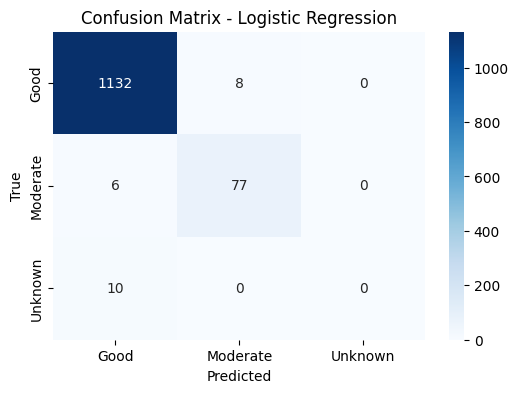


=== Random Forest ===
Accuracy: 0.9903
              precision    recall  f1-score   support

        Good       0.99      1.00      0.99      1140
    Moderate       0.97      1.00      0.98        83
     Unknown       1.00      0.10      0.18        10

    accuracy                           0.99      1233
   macro avg       0.99      0.70      0.72      1233
weighted avg       0.99      0.99      0.99      1233



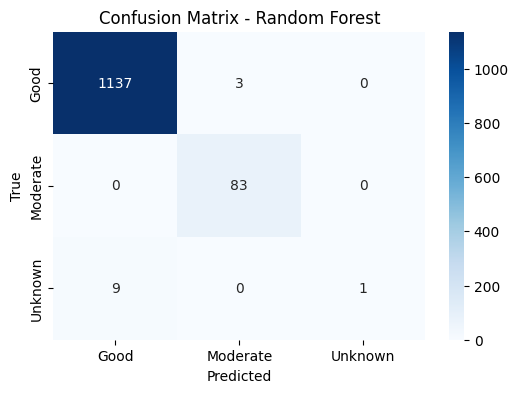


=== Gradient Boosting ===
Accuracy: 0.9895
              precision    recall  f1-score   support

        Good       0.99      0.99      0.99      1140
    Moderate       0.98      1.00      0.99        83
     Unknown       0.43      0.30      0.35        10

    accuracy                           0.99      1233
   macro avg       0.80      0.76      0.78      1233
weighted avg       0.99      0.99      0.99      1233



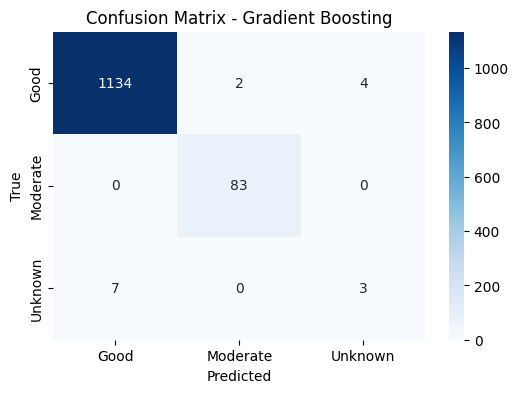

In [48]:
# --------------------------
# 10) Train & Evaluate Models
# --------------------------
def train_and_evaluate(model, model_name):
    clf = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {model_name} ===")
    print("Accuracy:", round(acc, 4))
    print(classification_report(y_test, y_pred, target_names=le_target.classes_))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le_target.classes_,
                yticklabels=le_target.classes_)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()



    # Run models
train_and_evaluate(LogisticRegression(max_iter=1000), "Logistic Regression")
train_and_evaluate(RandomForestClassifier(n_estimators=200, random_state=42), "Random Forest")
train_and_evaluate(GradientBoostingClassifier(random_state=42), "Gradient Boosting")

In [49]:
# --------------------------
# 11) Save Final Model
# --------------------------
final_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

final_model.fit(X_train, y_train)

joblib.dump(final_model, "aqi_predictor_with_pm.pkl")
joblib.dump(le_target, "label_encoder.pkl")

print("✅ Final model & encoder saved successfully!")

✅ Final model & encoder saved successfully!
